# Exploring Dandiset 001174: Calcium Imaging in SMA and M1 of Macaques

*Notebook generated with the assistance of AI. Please be cautious interpreting the code or results, and verify all outputs for your own research needs.*

---

## Dandiset Overview

**Title:** Calcium imaging in SMA and M1 of macaques  
**DOI:** [10.48324/dandi.001174/0.250331.2218](https://doi.org/10.48324/dandi.001174/0.250331.2218)  
**Link:** [Dandiset 001174 on DANDI Archive](https://dandiarchive.org/dandiset/001174/0.250331.2218)

This dandiset contains in vivo calcium imaging recordings from the supplementary motor area (SMA) and primary motor cortex (M1) of rhesus macaques. Using genetically encoded calcium indicators (GCaMP6f) and miniature microscopes, data were collected while macaques were at rest and during an arm-reaching task. The dataset includes raw calcium imaging videos, segmented cell traces, cell masks, and related metadata, all stored in NWB (Neurodata Without Borders) files, organized by subject and session.

---

## What This Notebook Covers

- Overview of the dandiset file organization and contents
- Step-by-step demonstration of accessing NWB files via the DANDI API (streaming remote files)
- Inspection of key metadata (session, subject)
- Visualization of:
  - ROI (cell) spatial masks and their organization
  - Example fluorescence traces from individual and all cells
  - Raw imaging data frames (montage)
  - Event amplitude traces (processed cell activity)
- Analysis summaries, including event rates across cells
- Guidance for reanalysis and further exploration

---

## Required Packages

The following Python packages are required (already assumed installed):
- `dandi`
- `pynwb`
- `remfile`
- `h5py`
- `matplotlib`
- `numpy`

---

Let's begin by exploring the dandiset and accessing one of its files.

# %% [markdown]
## 1. Explore the Dandiset and List Available NWB Files

First, we'll use the DANDI API to list NWB files in Dandiset 001174 (version 0.250331.2218), and display their organization by subject/session.

In [1]:
from dandi.dandiapi import DandiAPIClient
from itertools import islice

# Connect to the DANDI archive and this dandiset
client = DandiAPIClient()
dandiset = client.get_dandiset("001174", "0.250331.2218")

# List the first 20 NWB files (may be more in the set)
assets = list(islice(dandiset.get_assets_by_glob("*.nwb"), 20))
print(f"Number of .nwb files shown: {len(assets)}\n")
for i, asset in enumerate(assets):
    print(f"{i+1}. {asset.path} - {asset.size/1e9:.2f} GB")

Number of .nwb files shown: 20

1. sub-V/sub-V_ses-20230309T110929_ophys.nwb - 10.66 GB
2. sub-Q/sub-Q_ophys.nwb - 0.79 GB
3. sub-Q/sub-Q_ses-20220922T131747_ophys.nwb - 0.79 GB
4. sub-Q/sub-Q_ses-20221003T131952_ophys.nwb - 1.70 GB
5. sub-Q/sub-Q_ses-20221028T121142_ophys.nwb - 1.56 GB
6. sub-Q/sub-Q_ses-20221201T132256_ophys.nwb - 1.66 GB
7. sub-Q/sub-Q_ses-20221202T122907_ophys.nwb - 1.57 GB
8. sub-Q/sub-Q_ses-20221206T121002_ophys.nwb - 25.12 GB
9. sub-Q/sub-Q_ses-20220915T133954_ophys.nwb - 1.18 GB
10. sub-Q/sub-Q_ses-20221201T134628_ophys.nwb - 0.84 GB
11. sub-Q/sub-Q_ses-20221028T123313_ophys.nwb - 1.12 GB
12. sub-Q/sub-Q_ses-20220922T133032_ophys.nwb - 1.57 GB
13. sub-Q/sub-Q_ses-20221003T134805_ophys.nwb - 1.56 GB
14. sub-Q/sub-Q_ses-20221202T125146_ophys.nwb - 0.91 GB
15. sub-Q/sub-Q_ses-20221206T123719_ophys.nwb - 0.90 GB
16. sub-V/sub-V_ses-20230316T094035_ophys.nwb - 10.25 GB
17. sub-V/sub-V_ses-20230309T104556_ophys.nwb - 24.74 GB
18. sub-F/sub-F_ses-20240213T110430_ophys

These NWB files are organized by subject and session.
- Example filenames: `sub-Q/sub-Q_ses-20221206T121002_ophys.nwb`
- Each file contains imaging data for a single session and subject.

## 2. Load and Preview an Example NWB File

We'll select a representative NWB file (`sub-Q/sub-Q_ses-20221206T121002_ophys.nwb`) and stream it directly from the archive without downloading it, using `remfile` and `pynwb`.

This preview will extract:
- Session and subject metadata
- Key data shapes (movie, fluorescence traces, ROI masks)
- Example plots for understanding the structure

In [2]:
import pynwb
import h5py
import remfile
import numpy as np
import matplotlib.pyplot as plt

# Set up remote streaming to the example NWB file
asset_path = 'sub-Q/sub-Q_ses-20221206T121002_ophys.nwb'
asset = next(dandiset.get_assets_by_glob(asset_path))
url = asset.download_url
remote_file = remfile.File(url)
h5_file = h5py.File(remote_file, 'r')
io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
nwb = io.read()

# Inspect and print session and subject metadata
print('Session description:', nwb.session_description)
print('Session start time:', nwb.session_start_time)
print('Subject ID:', nwb.subject.subject_id)
print('Species:', nwb.subject.species)
print('Sex:', nwb.subject.sex)
print('Age:', getattr(nwb.subject, 'age', 'n/a'))

# Preview key data shapes
ophys = nwb.processing['ophys']
fluorescence = ophys.data_interfaces['Fluorescence']
rrs = fluorescence.roi_response_series['RoiResponseSeries']
fluor_shape = rrs.data.shape

plane_seg = ophys.data_interfaces['ImageSegmentation'].plane_segmentations['PlaneSegmentation']
roi_df = plane_seg.to_dataframe()
mask_sample = plane_seg['image_mask'].data[0]  # First cell mask
mask_shape = mask_sample.shape

onphs = nwb.acquisition['OnePhotonSeries']
movie_shape = onphs.data.shape

print('\n--- Data shapes ---')
print('Raw movie:', movie_shape)
print('Fluorescence traces:', fluor_shape)
print('Number of masks (cells):', len(roi_df))
print('Sample mask shape:', mask_shape)
print('\nColumns in ROI DataFrame:', list(roi_df.columns))

Session description: Calcium imaging in SMA during the spontaneous condition
Session start time: 2022-12-06 12:10:02.429000+00:00
Subject ID: Q
Species: Macaca mulatta
Sex: F
Age: P5Y



--- Data shapes ---
Raw movie: (12218, 1280, 800)
Fluorescence traces: (12218, 18)
Number of masks (cells): 18
Sample mask shape: (310, 186)

Columns in ROI DataFrame: ['image_mask']


## 3. Visualize an Example ROI (Cell) Mask and Fluorescence Trace

Most cellular analyses start with segmenting regions of interest (ROIs, i.e., cell footprints) and extracting their fluorescence traces. We'll visualize the mask for cell 0 and its trace for the first 5 minutes.

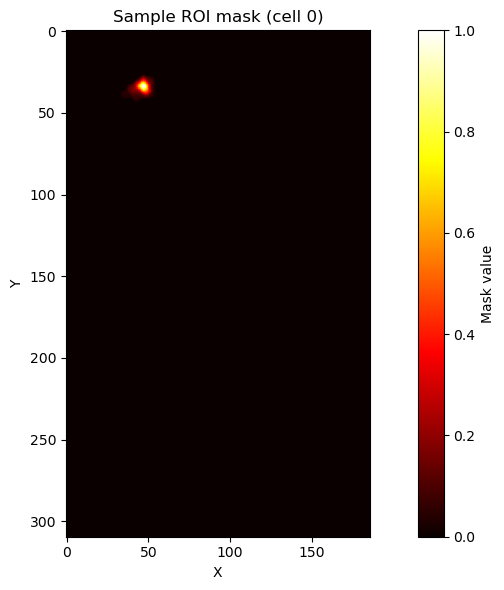

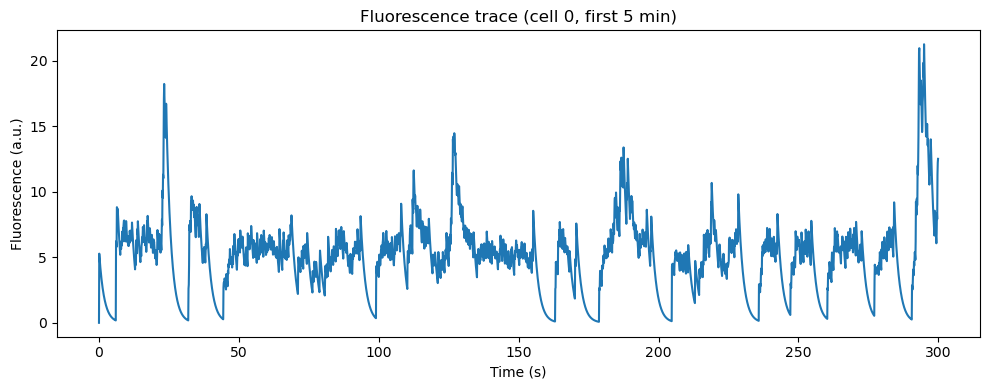

In [3]:
# Plot sample ROI mask for cell 0
plt.figure(figsize=(10,6))
plt.imshow(mask_sample, cmap='hot')
plt.title('Sample ROI mask (cell 0)')
plt.colorbar(label='Mask value')
plt.xlabel('X')
plt.ylabel('Y')
plt.tight_layout()
plt.show()

# Plot first 5 minutes of fluorescence trace for cell 0
sampling_rate = rrs.rate
n_seconds_plot = 5*60
n_samples_plot = int(n_seconds_plot * sampling_rate)
f_trace = rrs.data[:n_samples_plot,0]  # first ROI

plt.figure(figsize=(10,4))
plt.plot(np.arange(n_samples_plot)/sampling_rate, f_trace)
plt.xlabel('Time (s)')
plt.ylabel('Fluorescence (a.u.)')
plt.title('Fluorescence trace (cell 0, first 5 min)')
plt.tight_layout()
plt.show()

## 4. Visualize All Cell Masks — Spatial Organization Overview

Overlaying all ROI masks gives a sense of the distribution and potential overlap of segmentations across the field of view.

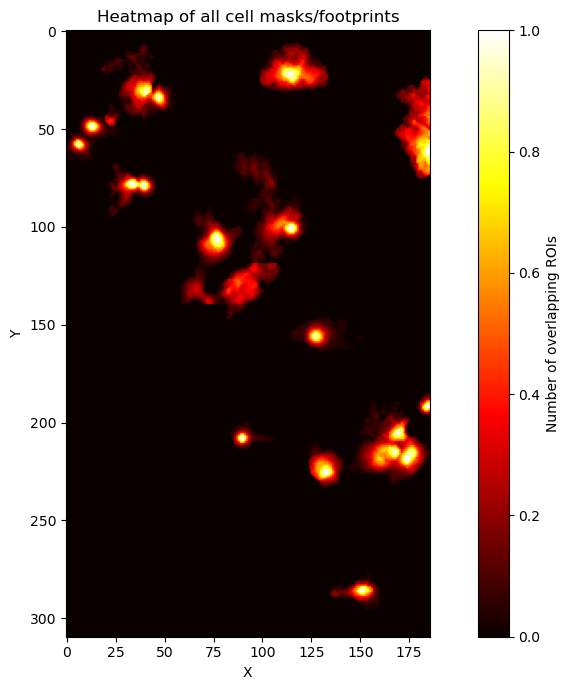

Cell ROI sizes (number of nonzero pixels):
[240, 201, 190, 641, 143, 262, 653, 176, 203, 637, 417, 411, 69, 475, 267, 304, 467, 2304]
Mean ± std of ROI size: 447.77777777777777 ± 482.62909102764706


In [4]:
# Stack all cell masks for a heatmap overlay
mask_arrays = [plane_seg['image_mask'].data[i][:] for i in range(len(roi_df))]
mask_stack = np.stack(mask_arrays, axis=0)
max_mask = np.max(mask_stack, axis=0)

plt.figure(figsize=(10,7))
plt.imshow(max_mask, cmap='hot')
plt.title('Heatmap of all cell masks/footprints')
plt.colorbar(label='Number of overlapping ROIs')
plt.xlabel('X')
plt.ylabel('Y')
plt.tight_layout()
plt.show()

# Print ROI size summary
roi_sizes = [np.count_nonzero(mask) for mask in mask_arrays]
print('Cell ROI sizes (number of nonzero pixels):')
print(roi_sizes)
print('Mean ± std of ROI size:', np.mean(roi_sizes), '±', np.std(roi_sizes))

## 5. Preview Raw Movie Frames (Montage)

Here we display a montage of the first 12 frames from the raw acquisition, to help users see the field of view and baseline imaging quality.

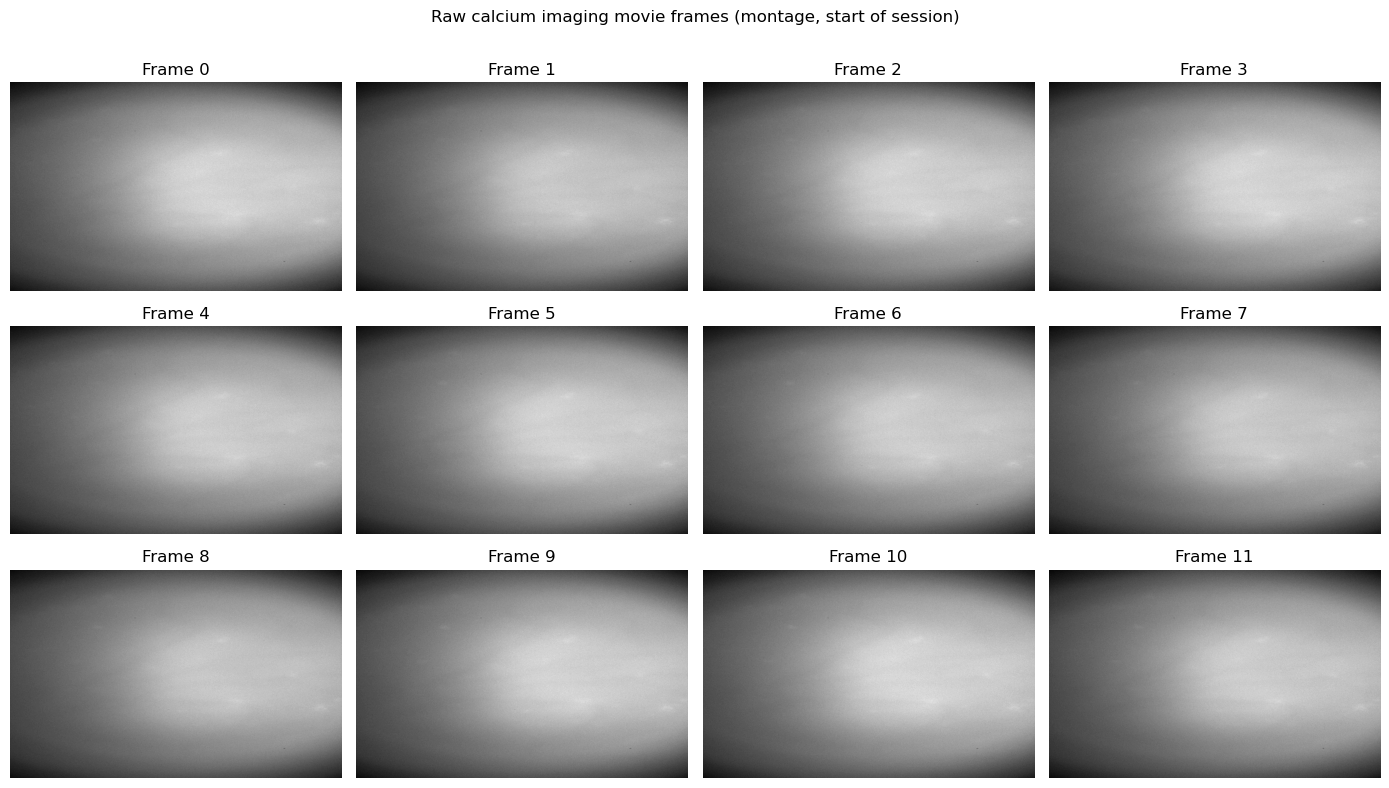

In [5]:
frames_to_show = 12  # Show, e.g., first 1.2 seconds at 10 Hz
movie_segment = onphs.data[:frames_to_show]

n_cols = 4
n_rows = int(np.ceil(frames_to_show / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14,8))
for i in range(frames_to_show):
    ax = axes[i // n_cols, i % n_cols]
    ax.imshow(movie_segment[i], cmap='gray', aspect='auto')
    ax.set_title(f'Frame {i}')
    ax.axis('off')
for i in range(frames_to_show, n_rows*n_cols):
    axes.flat[i].axis('off')
plt.suptitle('Raw calcium imaging movie frames (montage, start of session)')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

## 6. Processed Event Amplitudes: Visualization

The dataset provides not only raw fluorescence traces, but also processed "event amplitude" traces pinpointing times of detected calcium events for each cell. We plot cell 0's event amplitude trace for the first 5 minutes.

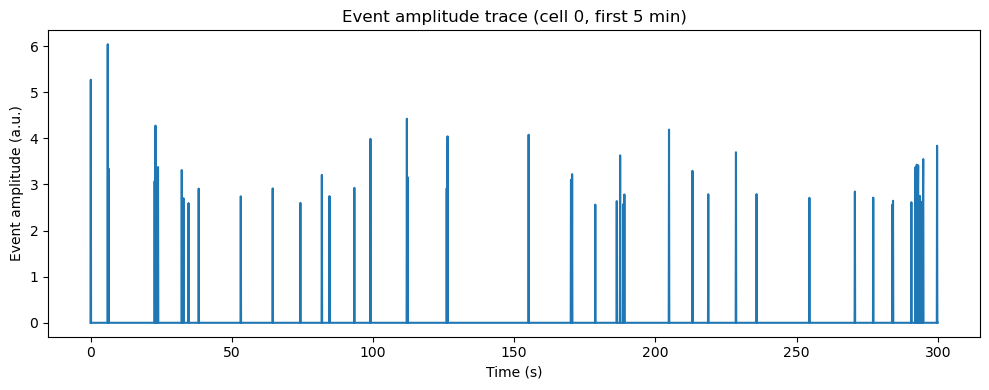

In [6]:
event_amp = ophys.data_interfaces['EventAmplitude']
ampl_trace = event_amp.data[:n_samples_plot,0]  # same window as above

plt.figure(figsize=(10,4))
plt.plot(np.arange(n_samples_plot)/sampling_rate, ampl_trace)
plt.xlabel('Time (s)')
plt.ylabel('Event amplitude (a.u.)')
plt.title('Event amplitude trace (cell 0, first 5 min)')
plt.tight_layout()
plt.show()

## 7. Carpet Plot: Traces for All Cells (First 500 Samples)

Plotting all cell traces together (with vertical offsets for clarity) can reveal heterogeneity and subtypes in cellular activity.

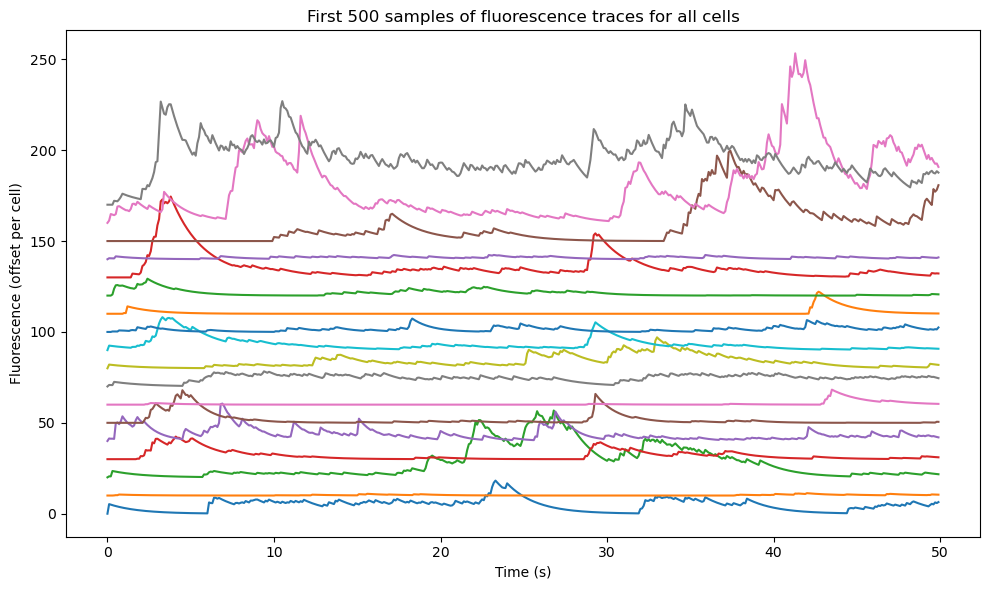

In [7]:
num_cells = rrs.data.shape[1]
time = np.arange(rrs.data.shape[0]) / sampling_rate

# Show the first 500 samples for each cell (for clarity)
window = 500
plt.figure(figsize=(10, 6))
for i in range(num_cells):
    plt.plot(time[:window], rrs.data[:window, i] + 10*i)
plt.xlabel('Time (s)')
plt.title('First 500 samples of fluorescence traces for all cells')
plt.ylabel('Fluorescence (offset per cell)')
plt.tight_layout()
plt.show()

## 8. How to Match Traces, Event Amplitudes, and Masks for a Specific Cell

Each ROI index corresponds to one cell across the various data structures:
- ROI index *i* in traces ↔ mask index *i* in ImageSegmentation
- You can visualize both together, or extract for further analysis

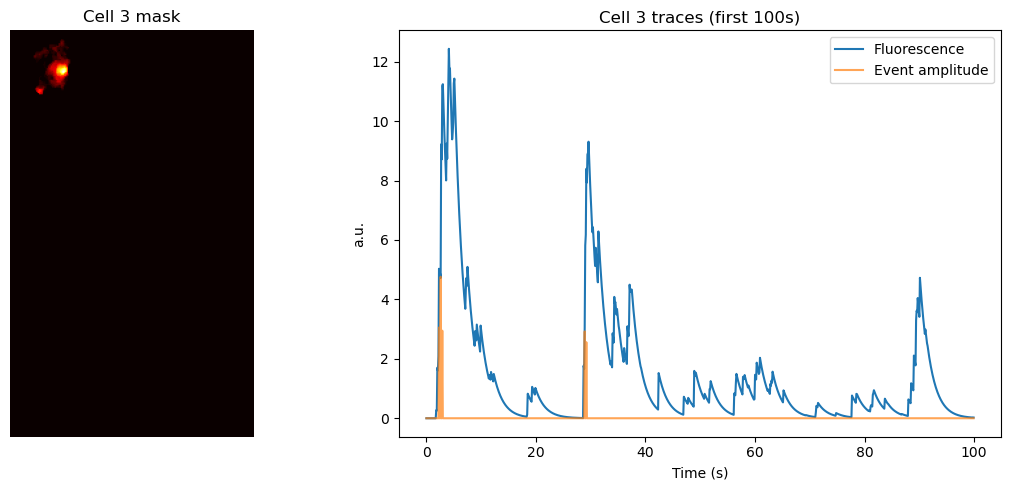

In [8]:
cell_idx = 3  # Example: cell 3
mask = plane_seg['image_mask'].data[cell_idx][:]
trace = rrs.data[:, cell_idx]
event_trace = event_amp.data[:, cell_idx]

plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.imshow(mask, cmap='hot')
plt.title(f'Cell {cell_idx} mask')
plt.axis('off')

plt.subplot(1,2,2)
plt.plot(time[:1000], trace[:1000], label='Fluorescence')
plt.plot(time[:1000], event_trace[:1000], label='Event amplitude', alpha=0.7)
plt.title(f'Cell {cell_idx} traces (first 100s)')
plt.xlabel('Time (s)')
plt.ylabel('a.u.')
plt.legend()
plt.tight_layout()
plt.show()

## 9. Quantitative Summary: Event Rates Across Cells

It's useful to check how active each cell is. Here, we count nonzero events (spikes) and compute a per-minute rate.

Event rates (per min) for each cell:
[10.06711409395973, 1.031265346210509, 6.973318055328204, 1.5714519561302995, 23.080700605663775, 1.8169913242756588, 1.2276968407267965, 1.6205598297593715, 3.584874774922246, 2.2589621869373055, 4.075953511212965, 6.236699950892127, 0.6384023571779341, 5.303650351939761, 1.031265346210509, 49.402520870846296, 39.138975282370275, 70.96087739400883]
Mean ± std event rate: 12.778960004365144 ± 19.52947379705454


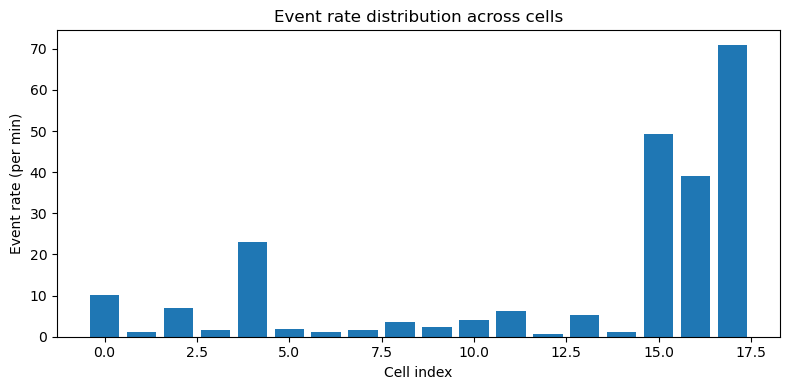

In [9]:
# Compute event rate (number of nonzero events per minute)
minutes = rrs.data.shape[0] / sampling_rate / 60
cell_event_counts = [(event_amp.data[:,i] > 0).sum() for i in range(num_cells)]
cell_event_rates = [count / minutes for count in cell_event_counts]
print('Event rates (per min) for each cell:')
print(cell_event_rates)
print('Mean ± std event rate:', np.mean(cell_event_rates), '±', np.std(cell_event_rates))

plt.figure(figsize=(8,4))
plt.bar(np.arange(num_cells), cell_event_rates)
plt.xlabel('Cell index')
plt.ylabel('Event rate (per min)')
plt.title('Event rate distribution across cells')
plt.tight_layout()
plt.show()

## 10. Tips for Further Exploration and Reanalysis

- Iterate through all NWB files/sessions to summarize or compare multiple subjects or conditions.
- Analyze synchrony/correlation between cell activity traces.
- Overlay cell masks on mean/maximum projection of the movie.
- Export summary statistics for further group-level or behavioral analyses.
- Explore the dataset interactively in [NeuroSift](https://neurosift.app/nwb?dandisetId=001174&dandisetVersion=0.250331.2218&path=sub-Q/sub-Q_ses-20221206T121002_ophys.nwb).

---

## Closing and Cleanup

Always close the NWB, HDF5, and remote file streams when done.

This notebook demonstrated core strategies for accessing and exploring Dandiset 001174 via the DANDI API, streaming NWB files, and visualizing and analyzing cellular calcium imaging data. You can now adapt these code patterns to your own reanalysis and hypothesis testing.

If you use these data, please cite the Dandiset as described in the opening section.


In [10]:
# Clean up resources
io.close()
h5_file.close()
remote_file.close()